In [14]:
import matplotlib.pyplot as plt
import numpy as np
import miepython
import copy
from scipy.spatial import cKDTree
import pandas as pd
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, ImageFilter
from matplotlib import colormaps
import torch.optim as optim
import torch.nn as nn
from os import listdir
from os.path import isfile, join
import re
import random
import imageio.v2 as iio

# Functions

In [54]:
def tau(v,v_min,v_max):
    # Compute optical depth given a pd voltage (v)
    # v_min is the pd voltage with no mist or laser
    # v_max is pd voltage with laser and no mist
    # Assumes linear response of pd to light intensity (should be improved in future)
    return np.log((v_max - v_min)/(v - v_min))

def get_files(dir, key=".*\.png"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    return files

def get_image(image_path, height, width):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    image = image.resize((height,width))
    pixel_values = list(image.getdata())
    if image.mode == "RGB":
        channels = 3
    elif image.mode == "L":
        channels = 1
    elif image.mode == "RGBA":
        channels = 4
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((width, height, channels))
    sum_vales = pixel_values[:,:,0]+pixel_values[:,:,1]+pixel_values[:,:,2]
    return sum_vales[:,:]/sum_vales[:,:].max()

# Main

RGB


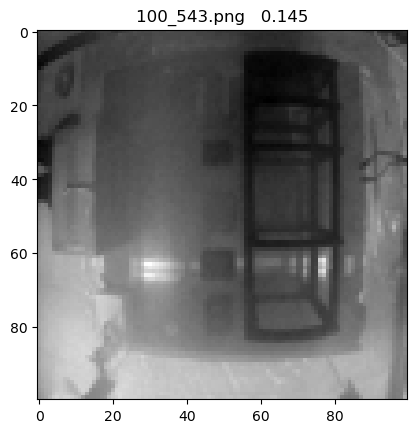

RGB


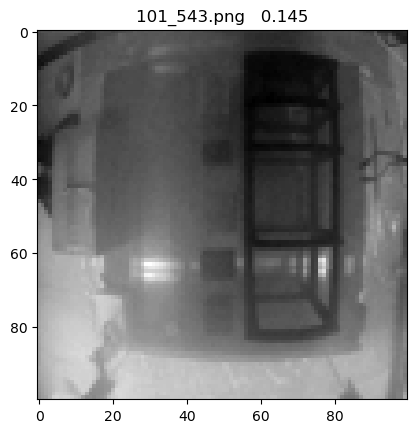

RGB


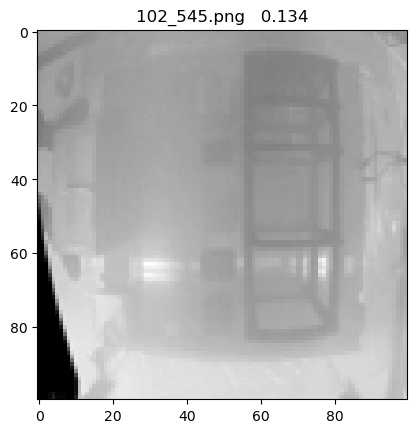

RGB


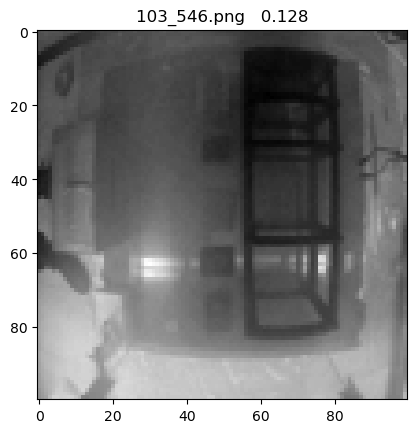

RGB


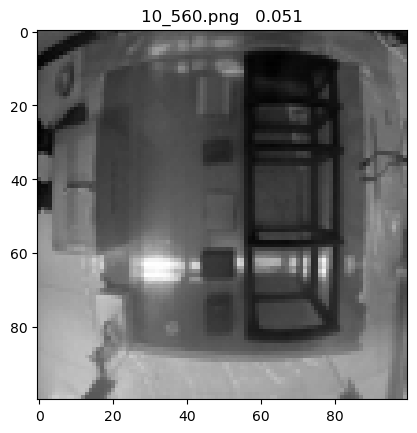

RGB


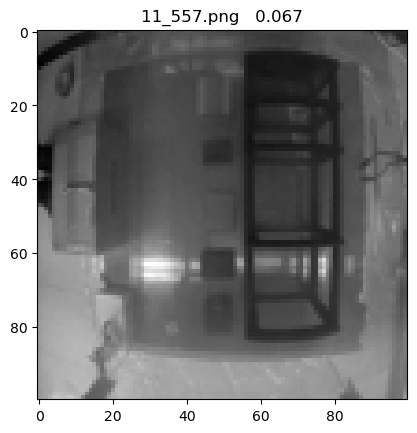

RGB


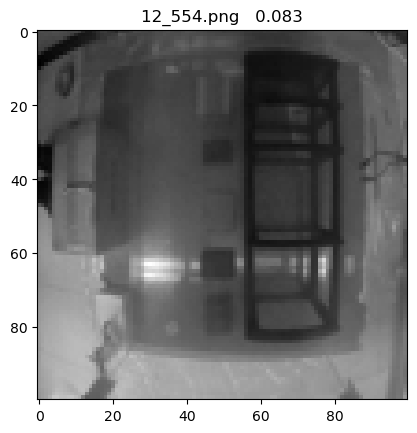

RGB


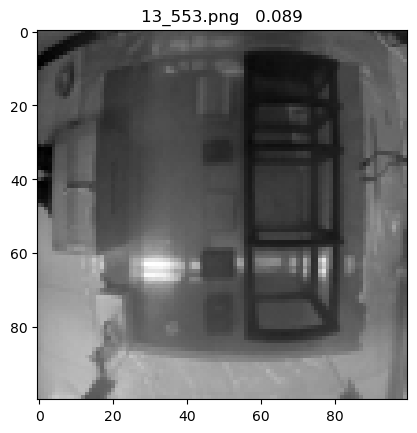

RGB


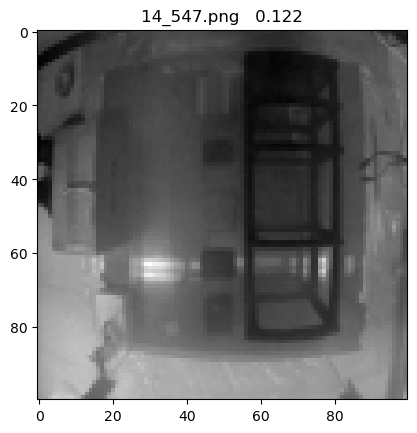

RGB


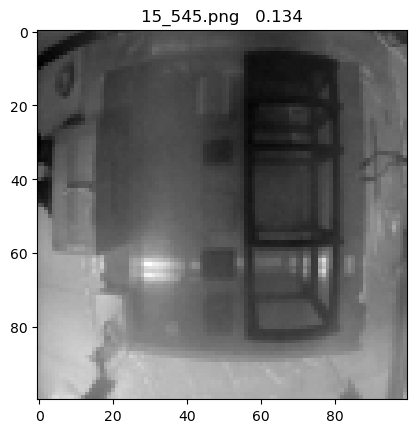

RGB


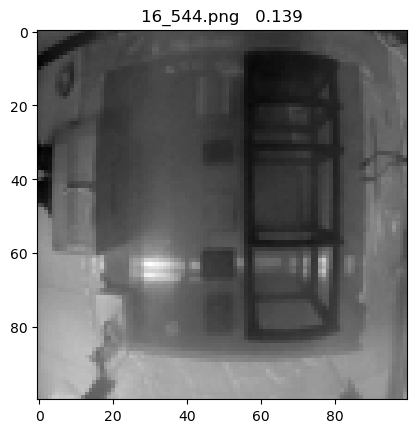

RGB


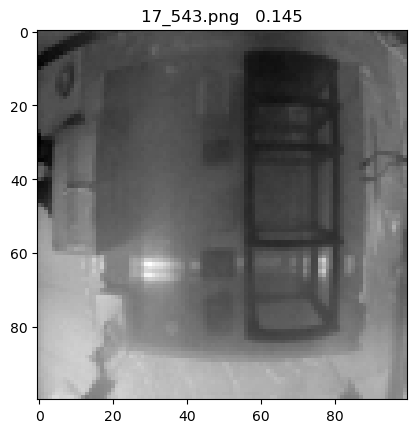

RGB


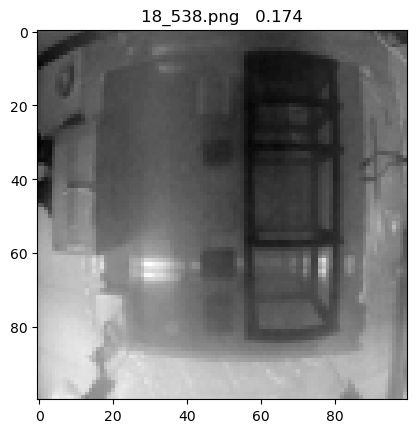

RGB


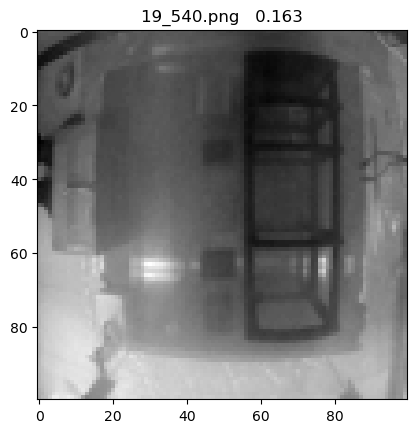

RGB


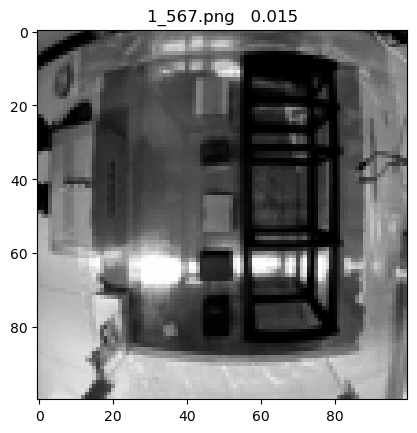

RGB


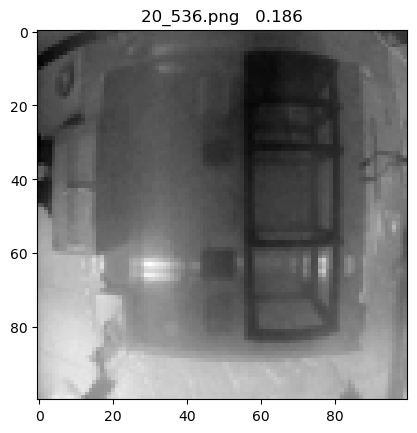

RGB


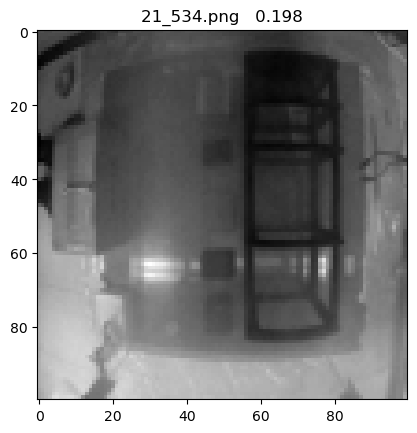

RGB


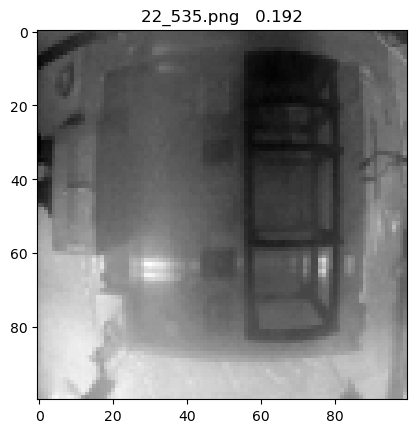

RGB


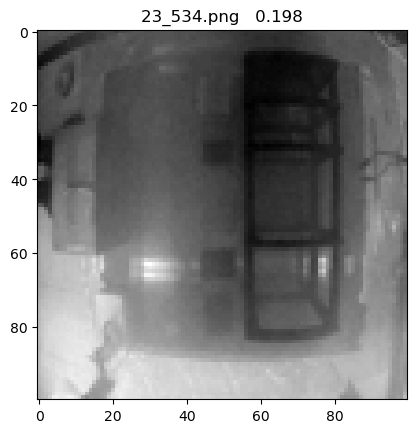

RGB


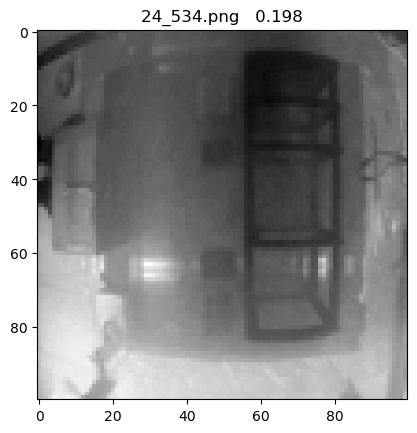

RGB


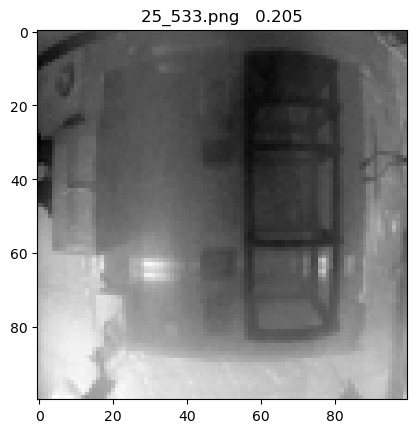

RGB


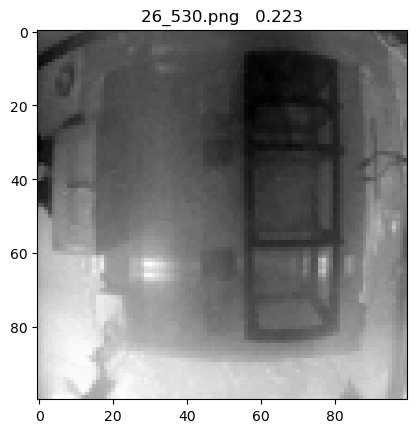

RGB


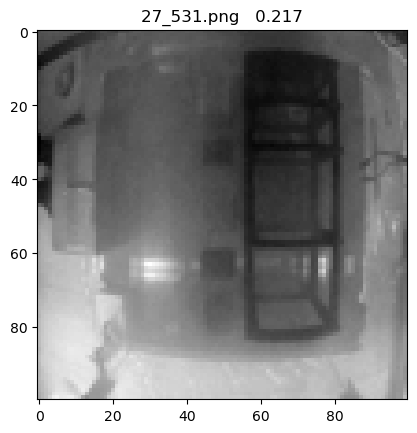

RGB


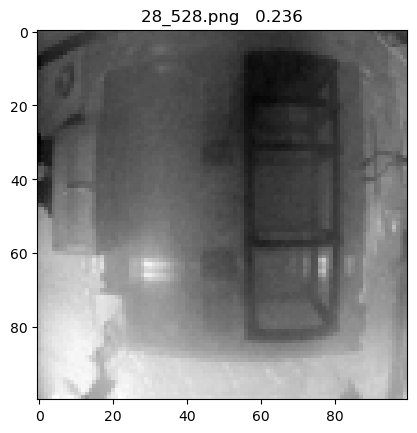

RGB


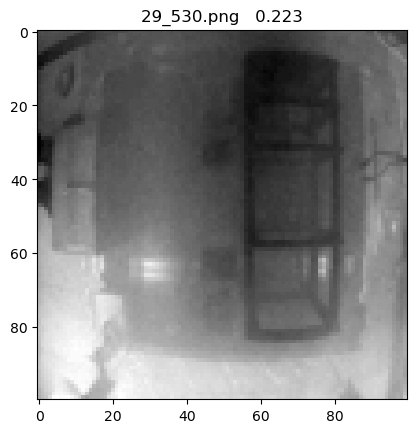

RGB


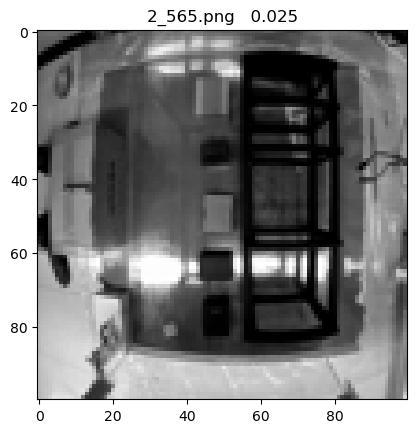

RGB


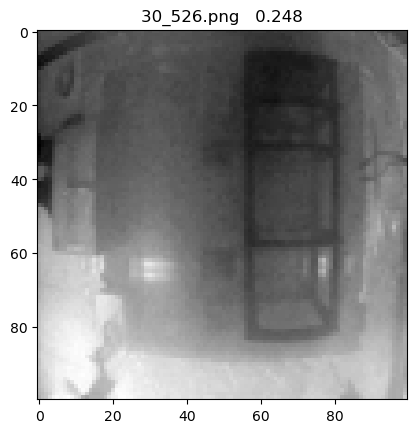

RGB


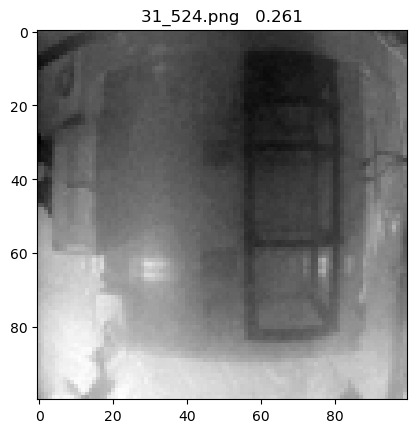

RGB


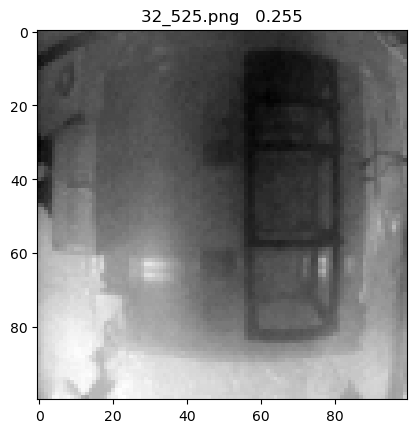

RGB


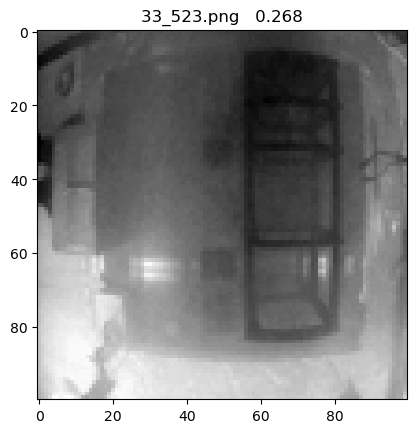

RGB


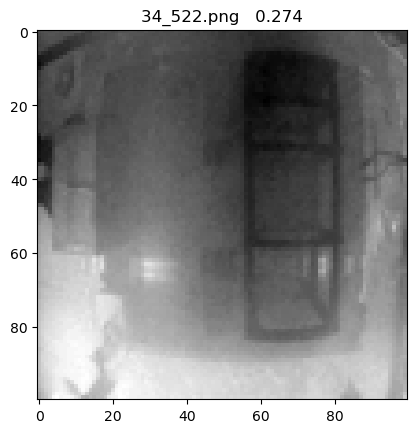

RGB


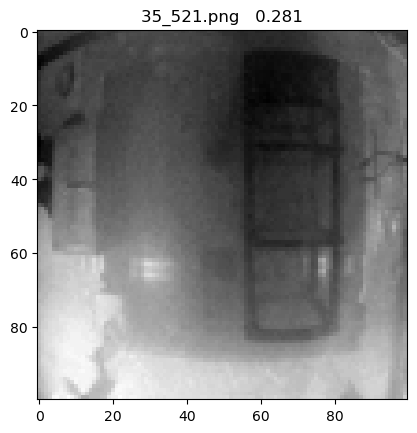

RGB


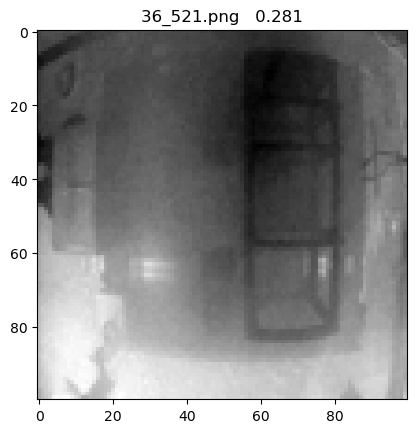

RGB


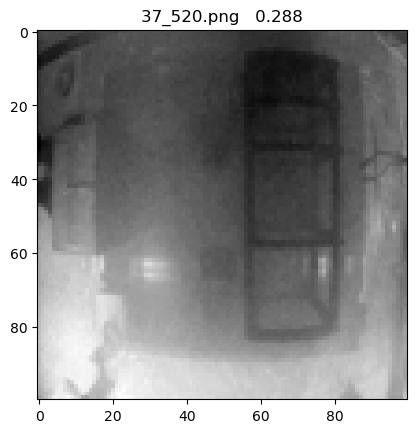

RGB


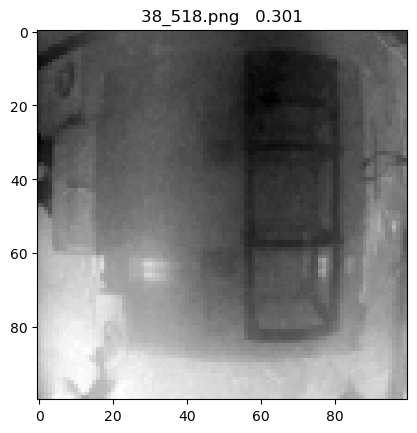

RGB


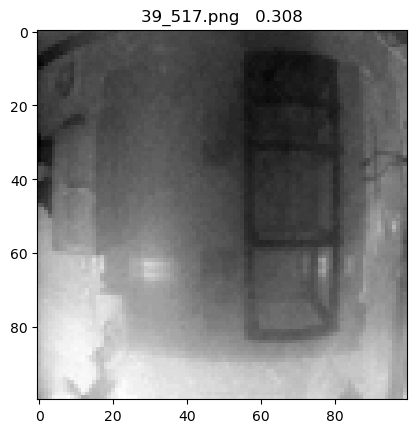

RGB


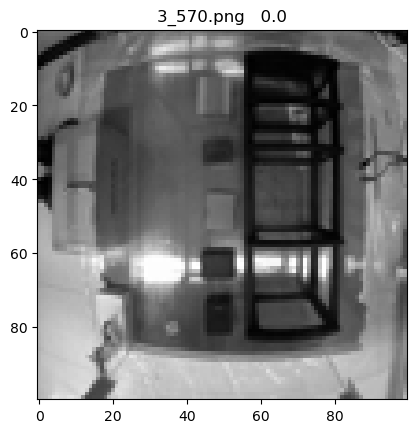

RGB


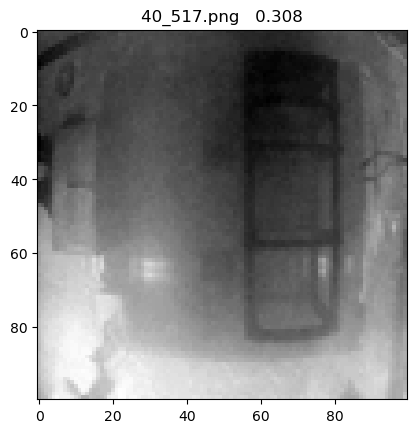

RGB


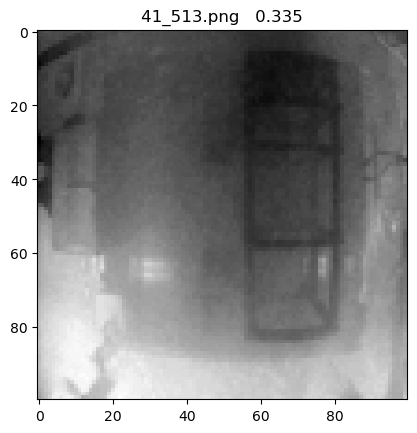

RGB


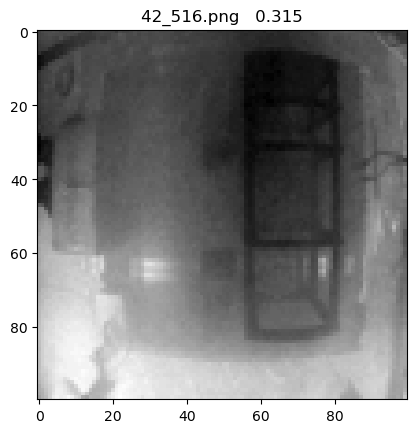

RGB


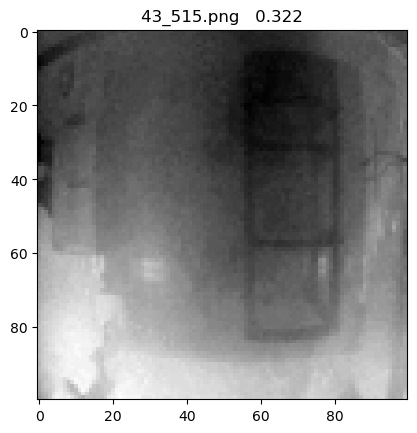

RGB


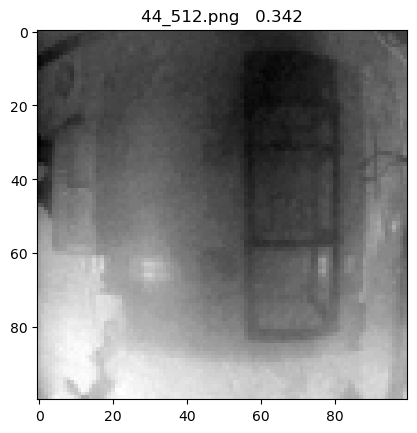

RGB


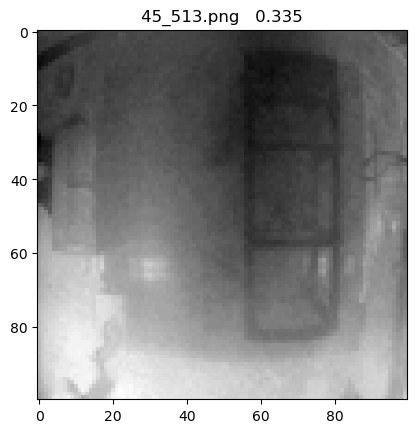

RGB


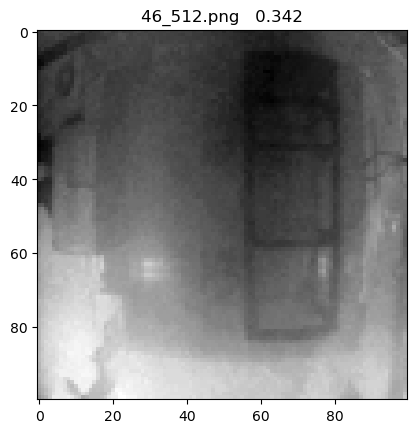

RGB


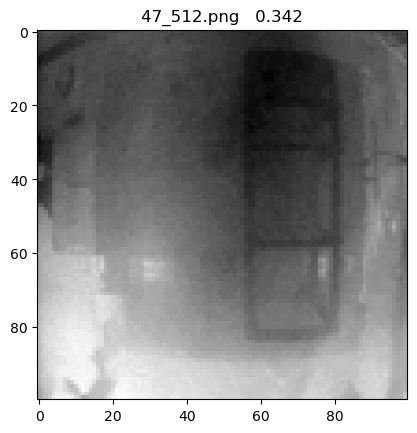

RGB


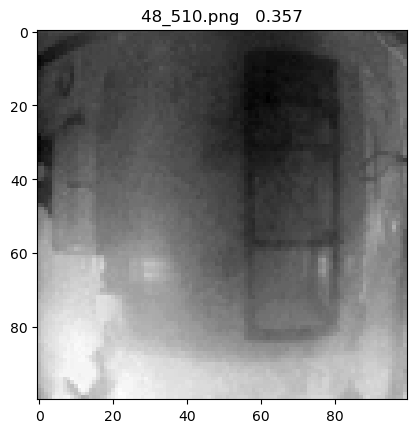

RGB


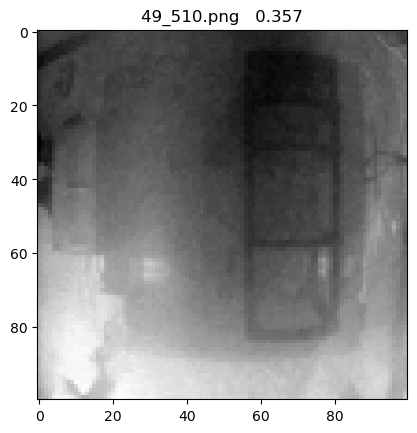

RGB


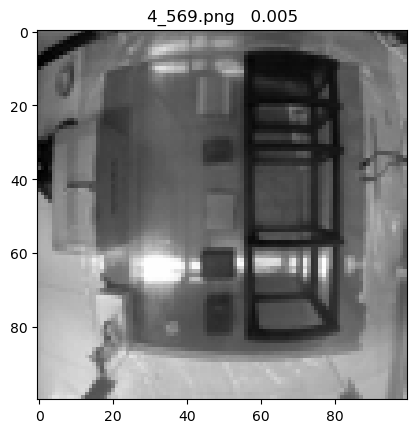

RGB


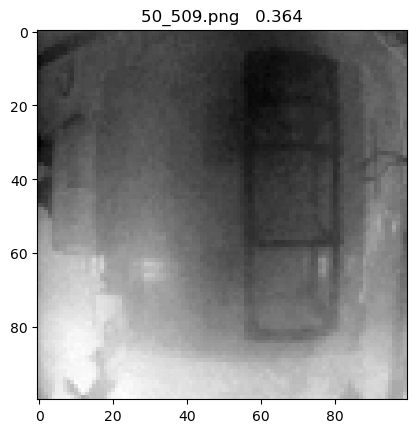

RGB


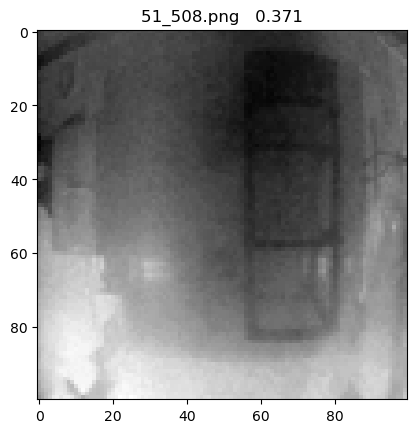

RGB


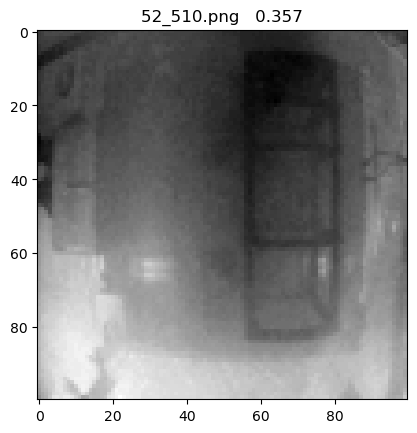

RGB


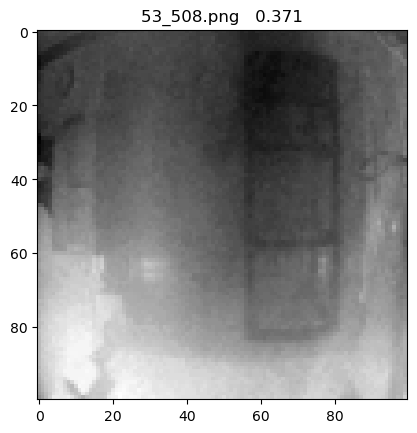

RGB


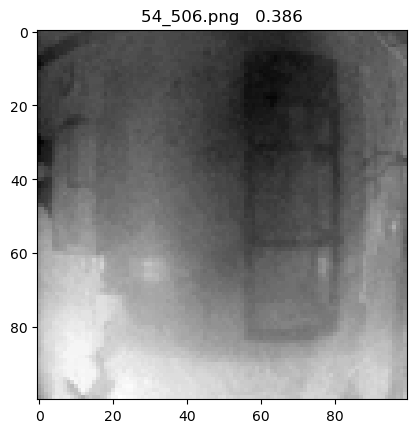

RGB


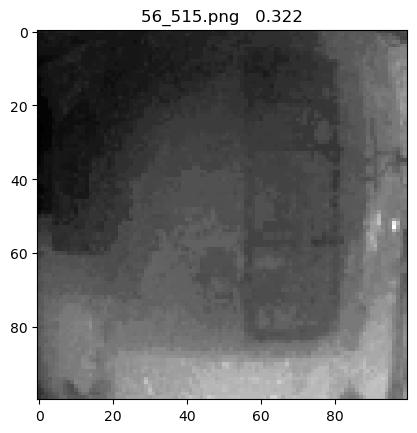

RGB


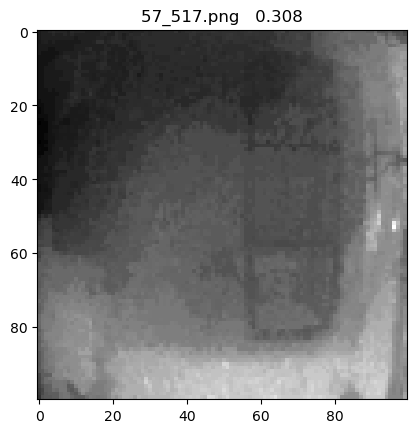

RGB


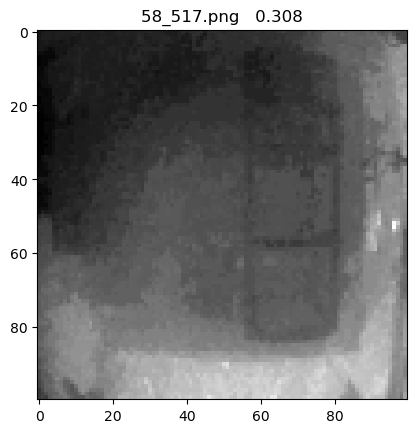

RGB


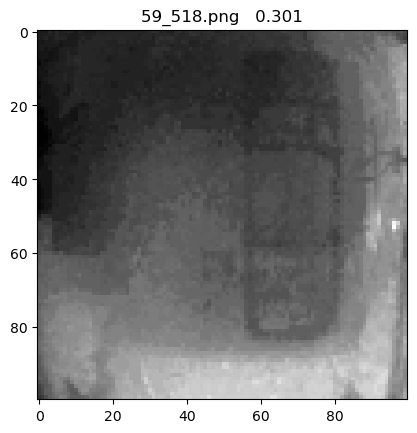

RGB


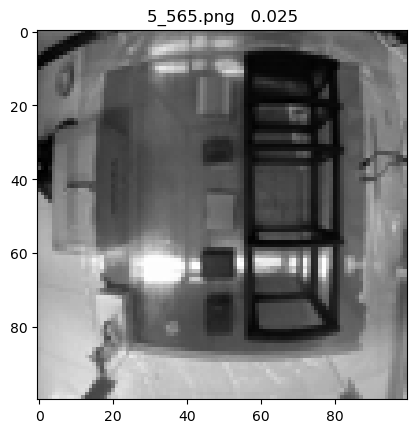

RGB


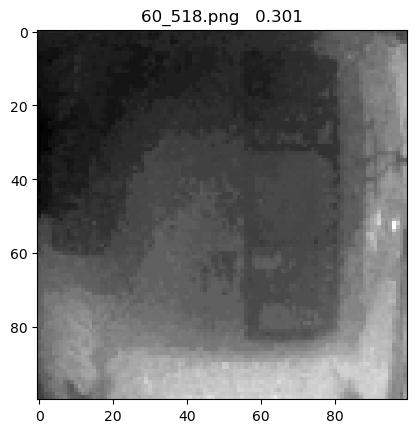

RGB


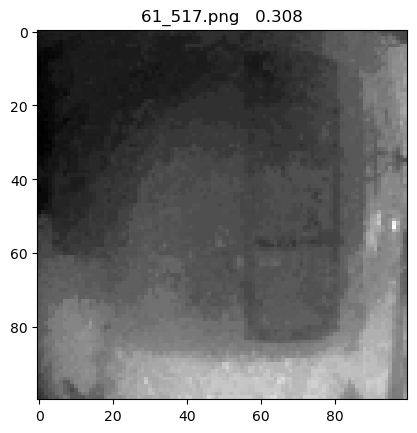

RGB


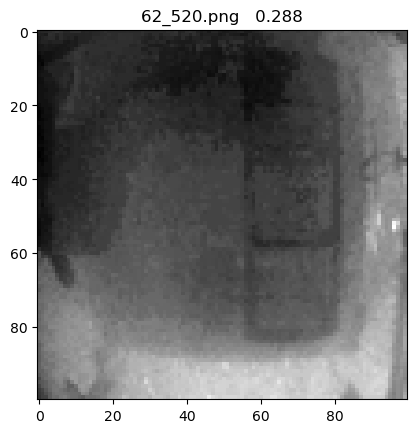

RGB


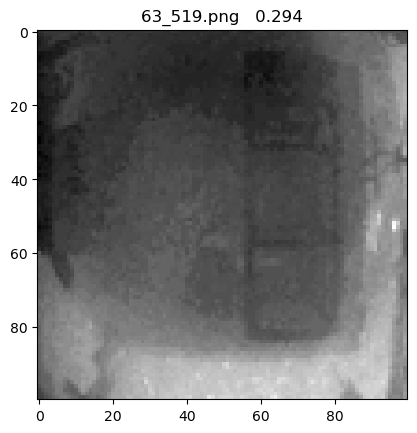

RGB


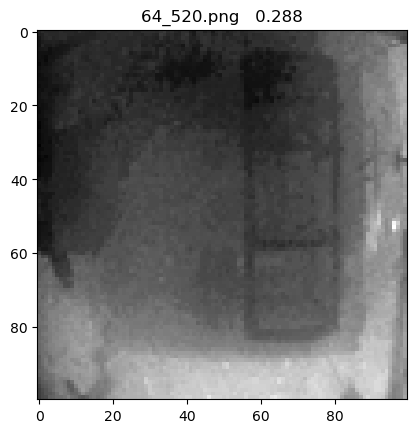

RGB


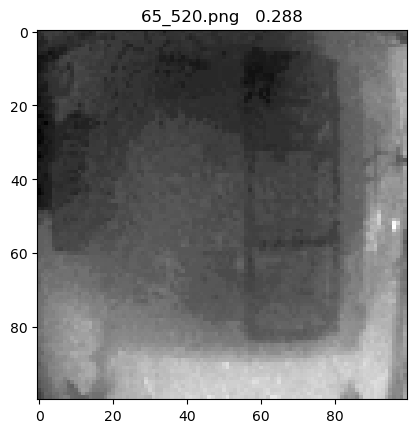

RGB


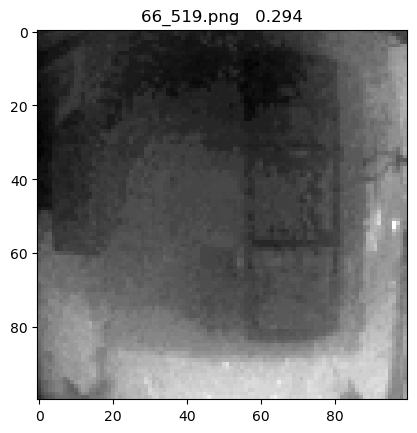

RGB


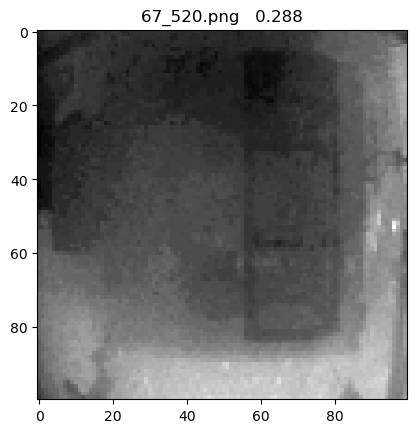

RGB


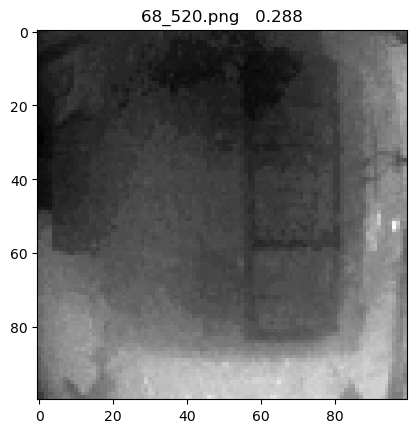

RGB


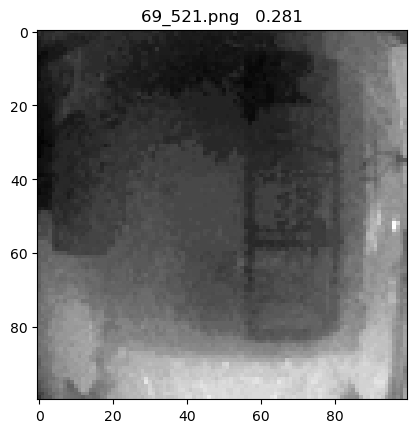

RGB


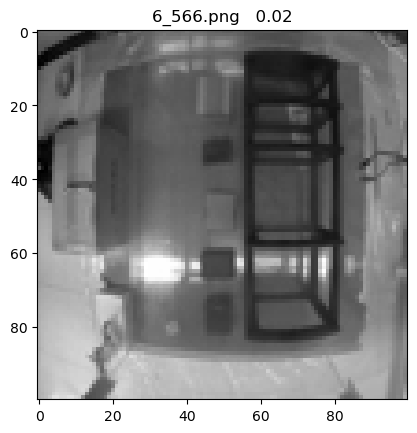

RGB


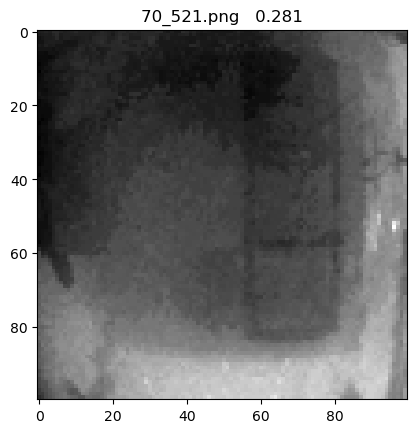

RGB


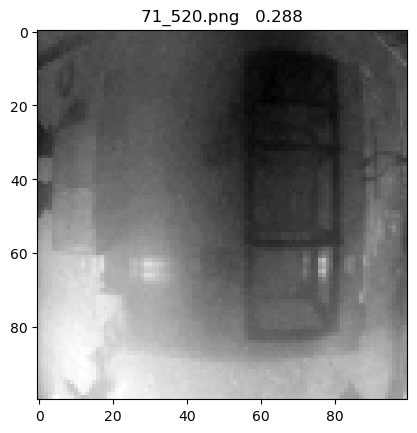

RGB


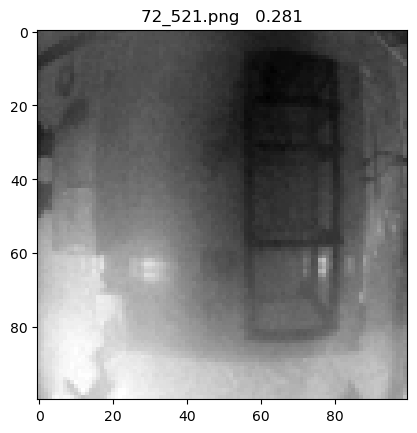

RGB


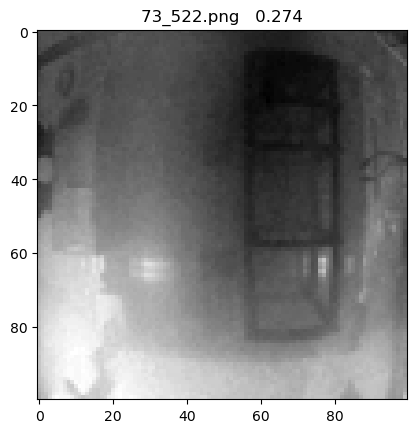

RGB


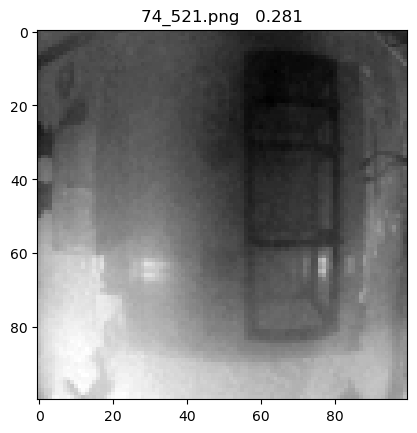

RGB


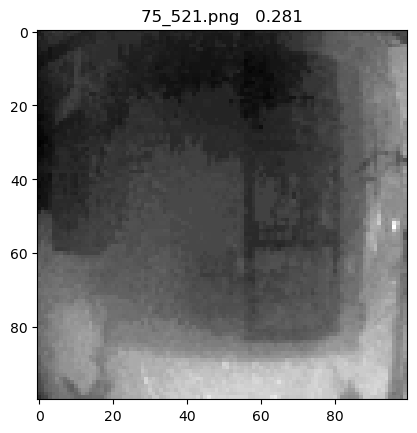

RGB


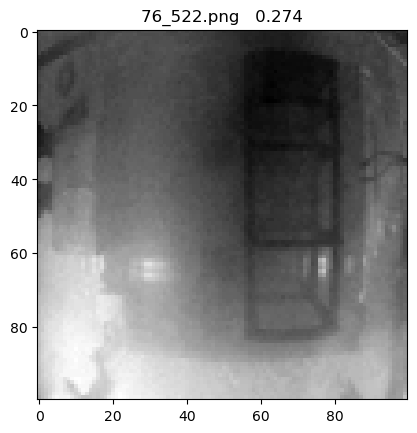

RGB


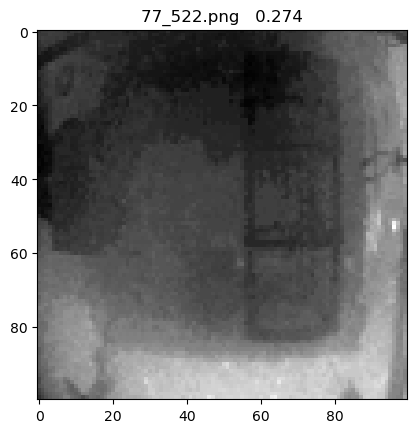

RGB


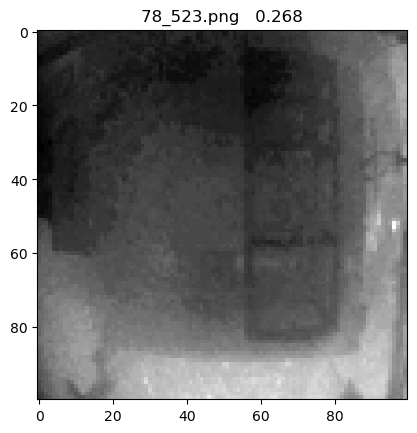

RGB


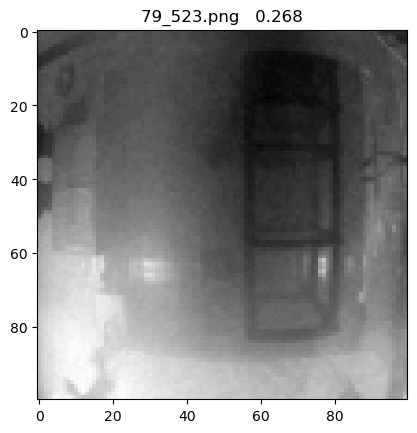

RGB


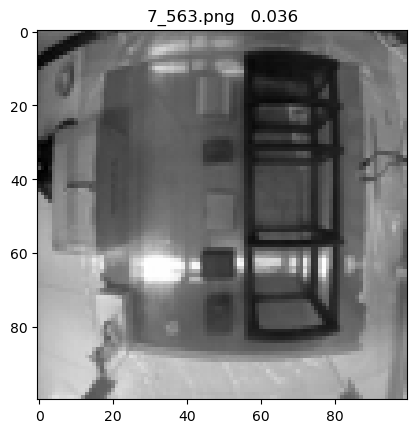

RGB


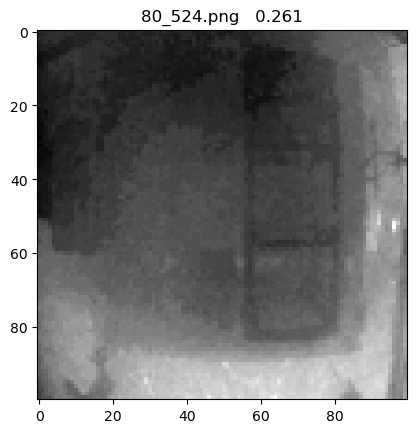

RGB


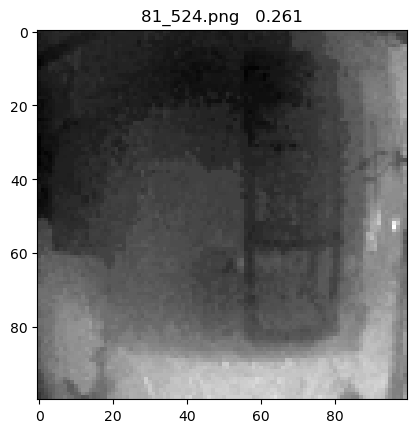

RGB


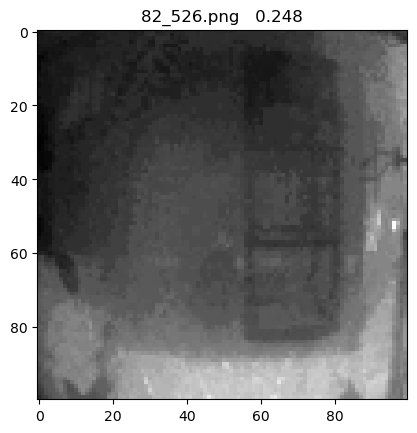

RGB


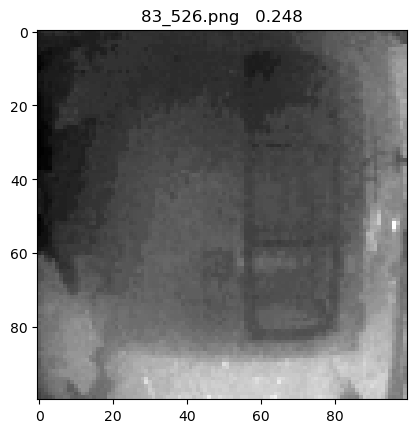

RGB


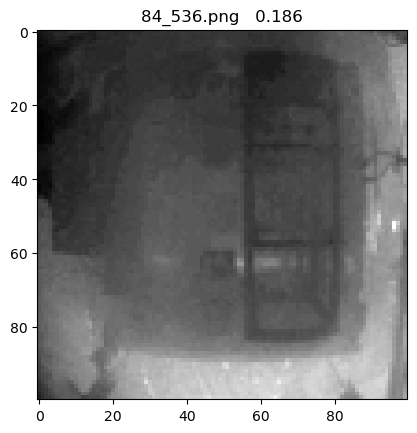

RGB


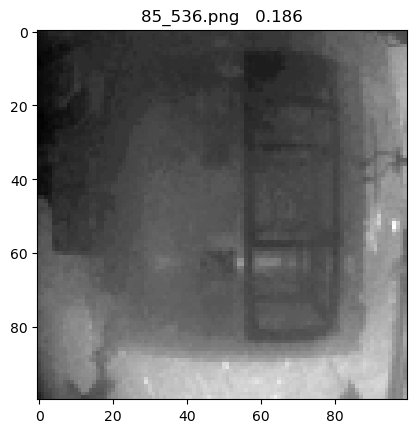

RGB


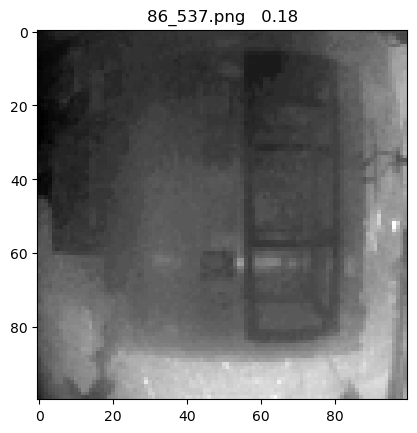

RGB


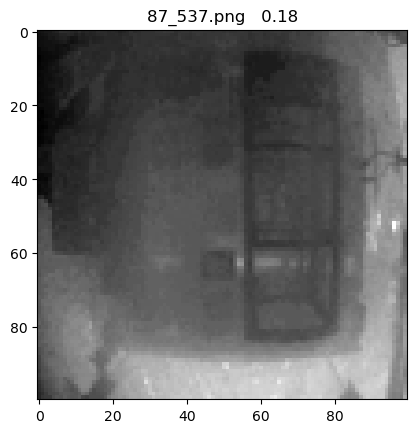

RGB


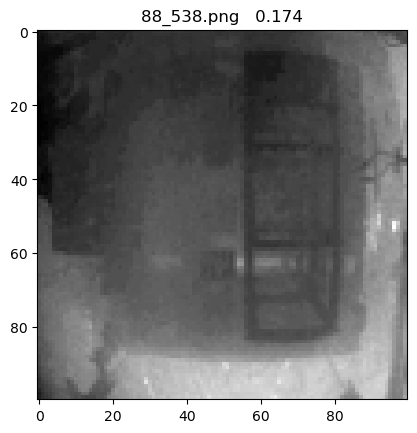

RGB


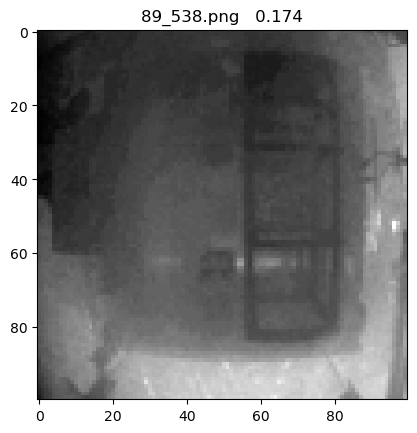

RGB


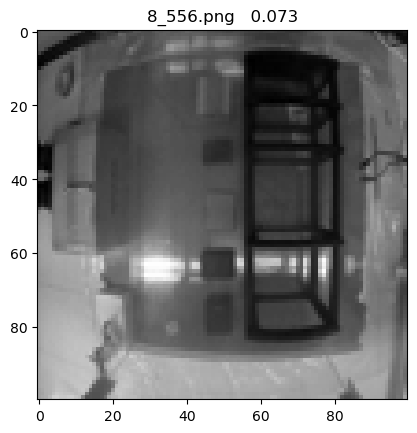

RGB


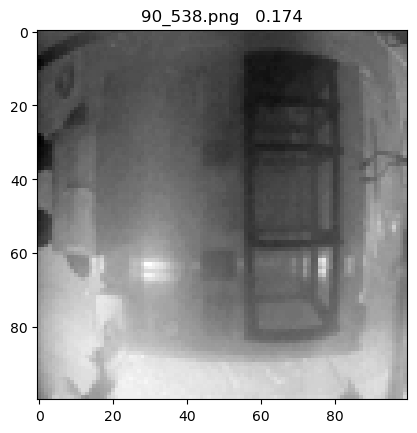

RGB


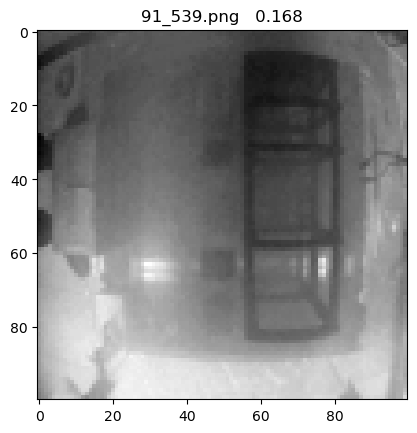

RGB


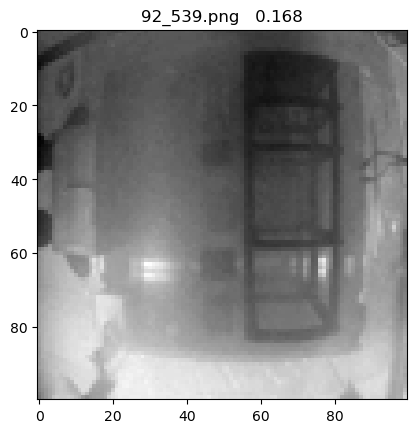

RGB


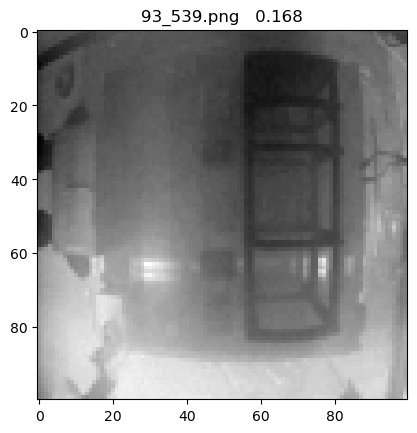

RGB


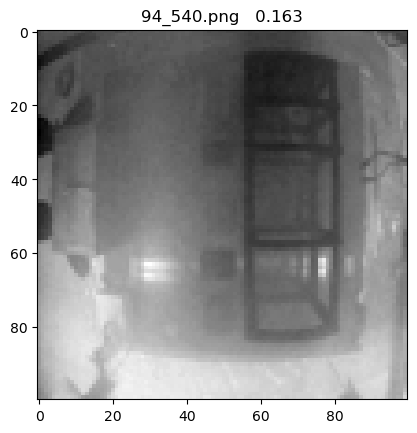

RGB


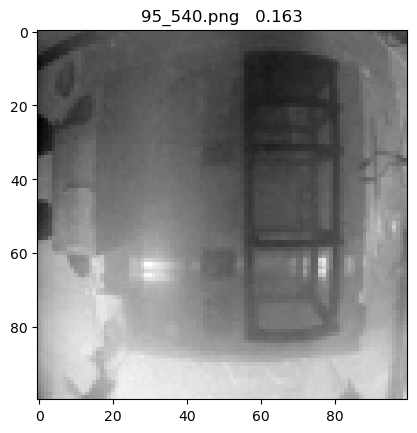

RGB


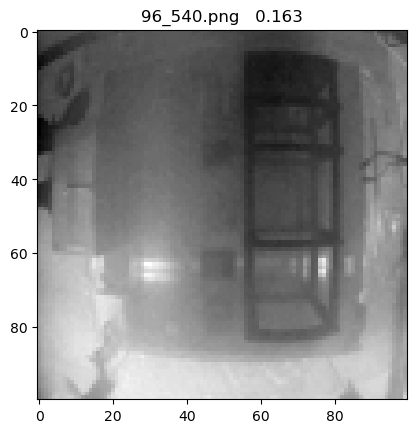

RGB


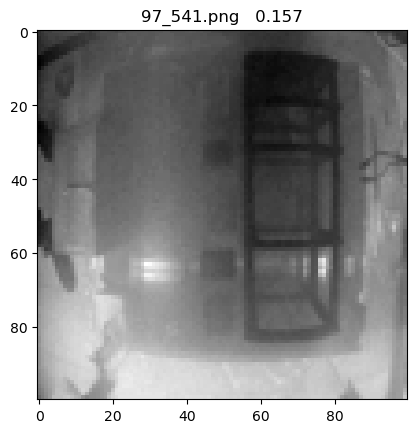

RGB


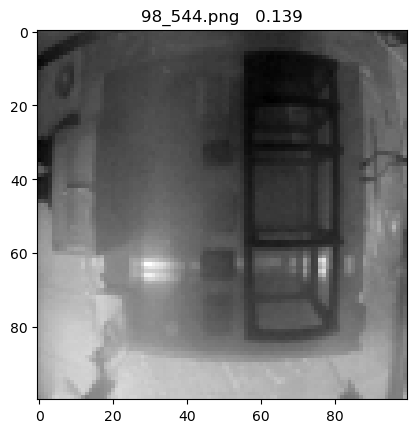

RGB


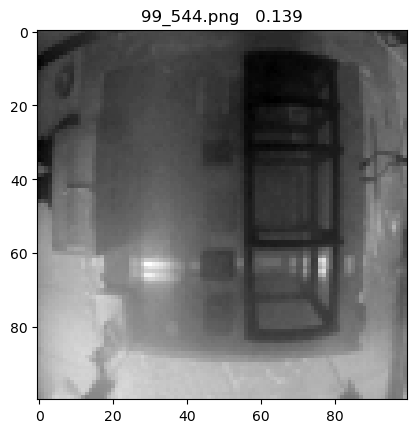

RGB


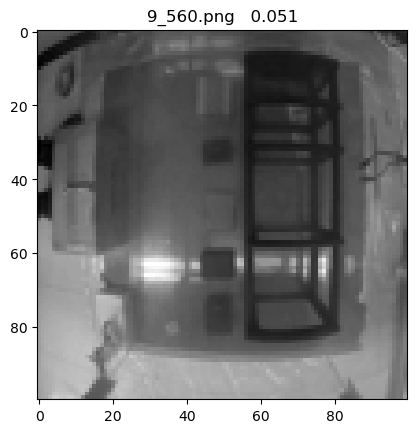

In [61]:
# Import images

dir = "pd_images/"
v_min = 370
v_max = 570
size = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

files = get_files(dir)
pd_ls = []
tau_ls = []
im_ls = []
for file in files:
    v = int(re.search(".*_(...)\.png",file)[1]) # This regex line pulls out the pd voltage in mV
    im = get_image(str(dir+file),size,size)
    plt.imshow(im,cmap="grey")
    plt.title(str(file+"   "+str(round(tau(v,v_min,v_max),3))))
    plt.show()
    pd_ls.append(v)
    tau_ls.append(tau(v,v_min,v_max))
    im_ls.append(im)

Epoch: 0


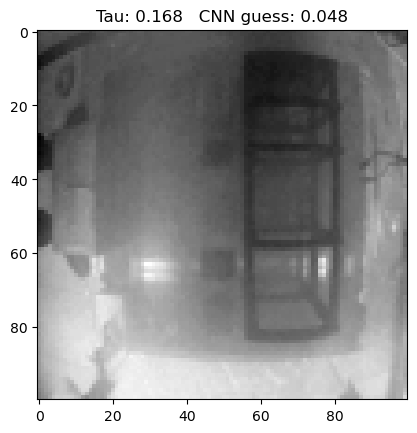

Epoch: 1000


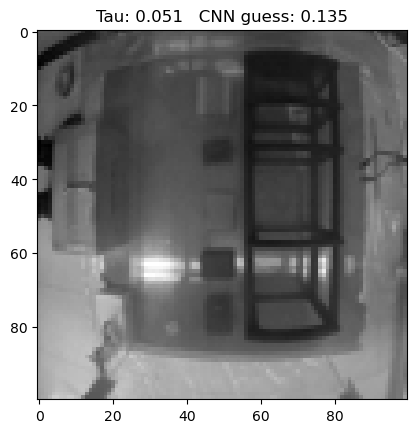

Epoch: 2000


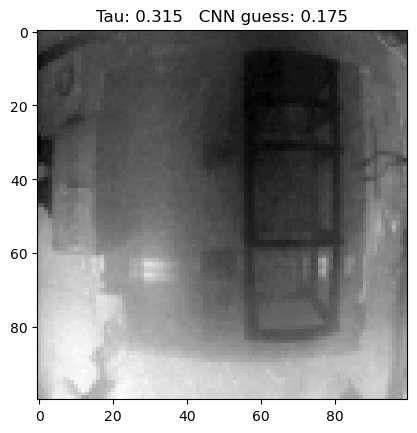

Epoch: 3000


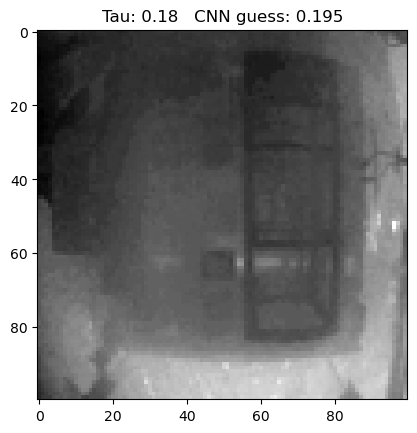

Epoch: 4000


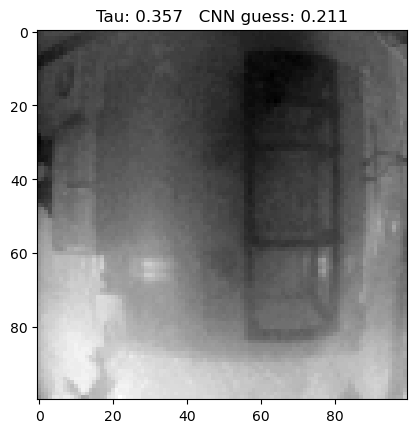

Complete!


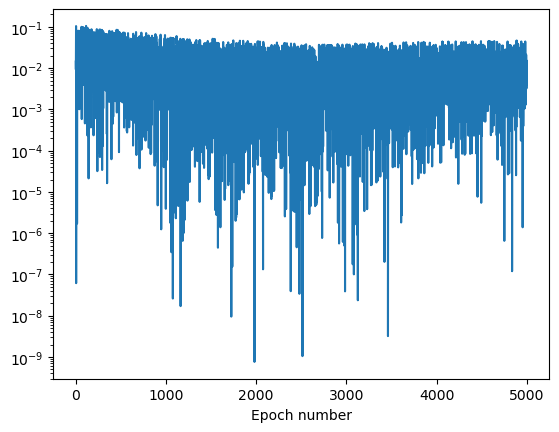

In [88]:
# Train CNN
# Define hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
myseed = 44
lr = 1e-5
n_epochs = 50000
plot_every = n_epochs/5

# Convert training data to tensors
im_tensor = torch.tensor(np.reshape(im_ls, (len(im_ls),size**2))).float().to(device)
tau_tensor = torch.tensor(np.reshape(tau_ls, (len(tau_ls),1))).float().to(device)

torch.manual_seed(myseed)

# Define CNN
hidden = 128
hidden2 = 128

model = nn.Sequential(
  nn.Linear(size**2, hidden),
  nn.ReLU(),
  nn.Linear(hidden, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2, hidden2),
  nn.Sigmoid(),
  nn.Linear(hidden2,1),
).to(device)

def mse_loss(input, target):
    return ((input - target) ** 2).sum() / input.data.nelement()
    
optimizer = optim.SGD(model.parameters(), lr=lr)
losses = []
losses_plot=[]
# Begin training loop
for epoch in range(n_epochs):

    num = random.randint(0,len(im_ls)-1)
    model.train()
    yhat = model(im_tensor[num])
    
    loss = mse_loss(tau_tensor[num], yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)

    losses_plot.append(loss.detach().numpy().item())

    if (epoch % plot_every)==0:
        print("Epoch:",epoch)
        im=plt.imshow(im_ls[num],cmap="grey")
        plt.title(str("Tau: "+str(round(tau_ls[num],3))+"   CNN guess: "+str(round(yhat.detach().numpy().item(),3))))
        plt.show()

print("Complete!")
plt.plot(losses_plot)
plt.xlabel("Epoch number")
plt.yscale("log")
plt.show()

# Utilities

In [19]:
# Relabel the image files using the recorded list of pd voltages:
# Input is directory of jpgs, which are renamed in order according to pd_ls and saved back to the dir as .pngs
dir = "pd_images/"
pd_ls = [567,565,570,569,565,566,563,556,560,560,557,554,553,547,545,544,543,538,540,536,534,
        535,534,534,533,530,531,528,530,526,524,525,523,522,521,521,520,518,517,517,513,516,
        515,512,513,512,512,510,510,509,508,510,508,506,509,515,517,517,518,518,517,520,519,
        520,520,519,520,520,521,521,520,521,522,521,521,522,522,523,523,524,524,526,526,536,
        536,537,537,538,538,538,539,539,539,540,540,540,541,544,544,543,543,545,546]

all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
files=[]
for file in all_files:
    match = re.search(".*\.jpg",file)
    if match != None:
        files.append(file)
files.sort()

if len(pd_ls)!=len(files):
    print("Wrong number!")

count=1
for i in range(len(pd_ls)):
    img = iio.imread(str(dir+files[i]))
    iio.imwrite(str(dir+str(count)+"_"+str(pd_ls[i])+".png"), img)
    count+=1